<a href="https://colab.research.google.com/github/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/blob/main/MV_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Objective: Predict Monthly Crude Palm Oil Price Using Gated Recurrent Units (GRUs)

###Load Libraries

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import tensorflow as tf
from keras.layers import Dense, Dropout, GRU
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

import matplotlib.dates as mdates
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

###Define Functions to Facilitate Metrics Evaluation

In [32]:
#To compute Mean Directional Accuracy
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

#Calculate the Mean Absolute Percentage Error
#def MAPE(y_true, y_pred): 
    #mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    #return mape

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Calculate the Root Mean Squared Error:
def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

###Load the Cleaned Data from Github

In [33]:
from pandas import read_csv
path = 'https://raw.githubusercontent.com/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/main/Cleaned_data/FS.csv'
df = read_csv(path)
df.head()

,date,cpo_pri,cno_pri,exmaus,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri,wti_spri,tmax_degC,tmin_degC,srad,q_mm,humidity
0,2010-12-01,323,455,2.991388,3102.61,423.45,844.0,468.0,578.0,28.67,30.43,20.2900,207.70504,117.7,79.261905
1,2011-01-01,345,546,2.991388,3100.45,415.85,799.0,485.0,557.0,24.49,31.20,20.9200,228.94287,4.5,82.193548
2,2011-02-01,362,595,2.991388,3199.41,410.77,718.0,466.0,552.0,22.06,31.97,21.0300,238.41747,25.1,74.839286
3,2011-03-01,376,636,2.991388,3281.67,414.82,614.0,442.0,574.0,21.64,32.69,21.6000,218.47599,53.6,77.935484
4,2011-04-01,383,738,2.991388,3261.65,451.04,619.0,429.0,595.0,22.30,32.37,22.0575,226.15010,166.0,80.450000


In [34]:
df.index = pd.to_datetime(df['date'], format='%Y.%m.%d')
del df['date']

In [35]:
df.head()

,cpo_pri,cno_pri,exmaus,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri,wti_spri,tmax_degC,tmin_degC,srad,q_mm,humidity
date,,,,,,,,,,,,,,
2010-12-01,323,455,2.991388,3102.61,423.45,844.0,468.0,578.0,28.67,30.43,20.2900,207.70504,117.7,79.261905
2011-01-01,345,546,2.991388,3100.45,415.85,799.0,485.0,557.0,24.49,31.20,20.9200,228.94287,4.5,82.193548
2011-02-01,362,595,2.991388,3199.41,410.77,718.0,466.0,552.0,22.06,31.97,21.0300,238.41747,25.1,74.839286
2011-03-01,376,636,2.991388,3281.67,414.82,614.0,442.0,574.0,21.64,32.69,21.6000,218.47599,53.6,77.935484
2011-04-01,383,738,2.991388,3261.65,451.04,619.0,429.0,595.0,22.30,32.37,22.0575,226.15010,166.0,80.450000


###Plot the Target Variable

Text(0.5, 0, 'Date')

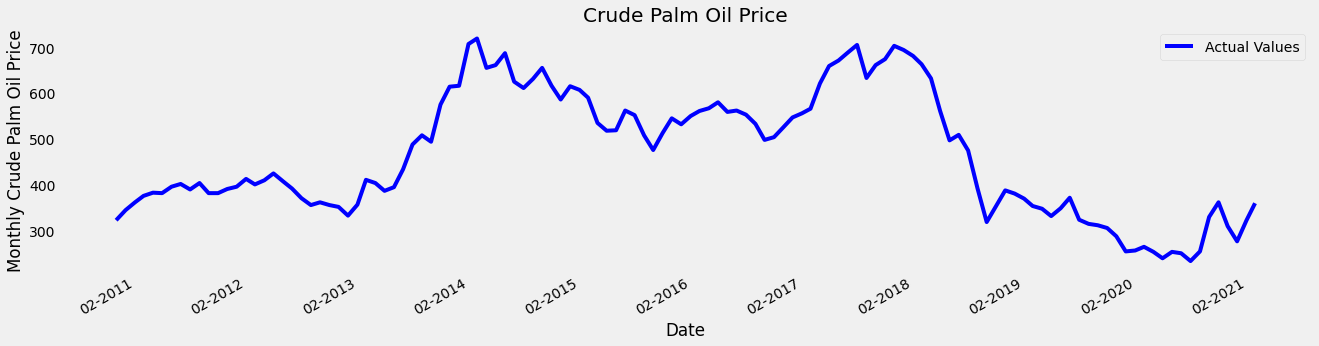

In [36]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(df.index, df['cpo_pri'], color = 'blue',  label = 'Test')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gcf().autofmt_xdate() # Rotation
plt.legend(['Actual Values', 'Crude Palm Oil Price 2002-2021'],loc='best')
plt.title('Crude Palm Oil Price')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Date')

###Visualize Multiple Time Series

In [37]:
fig = make_subplots(rows=6, cols=1)
fig.add_trace(
    go.Scatter(x=df.reset_index()['date'], y=df.reset_index()['cpo_pri'],name='crude palm oil price'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['date'], y=df.reset_index()['cno_pri'],name='coconut oil price'),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['date'], y=df.reset_index()['rps_pri'],name='rapeseed oil price'),
    row=3, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['date'], y=df.reset_index()['pno_pri'],name='peanut oil price'),
    row=4, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['date'], y=df.reset_index()['sbo_pri'],name='soybean oil price'),
    row=4, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['date'], y=df.reset_index()['wti_spri'],name='west texas intermediate spot price'),
    row=4, col=1

)
fig.update_layout(height=1000, width=1200, title_text="Time Series")
fig.show()

<Figure size 1800x720 with 0 Axes>

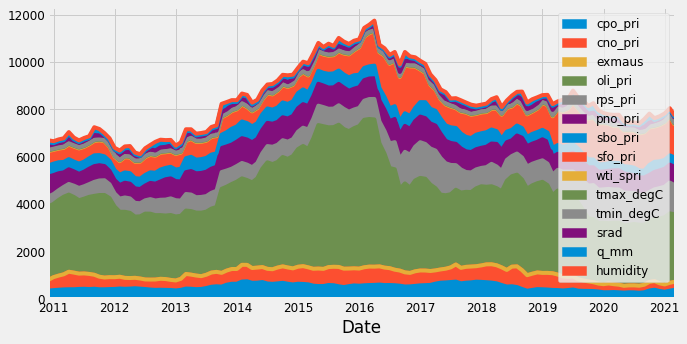

In [38]:
# Plot an area chart
plt.figure(figsize=(25,10))
ax = df.plot.area(fontsize=12);

# Additional customizations
ax.set_xlabel('Date');
ax.legend(fontsize=12);

##**Gated Recurrent Units Forecasting Technique (GRUs)**

###**Split Data into Train Test Segments**

In [39]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print('Train size:',len(train))
print('Test size:', len(test))

Train size: 99
Test size: 25


In [40]:
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

99 25


In [41]:
print(train.shape)
train.head()

(99, 14)


,cpo_pri,cno_pri,exmaus,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri,wti_spri,tmax_degC,tmin_degC,srad,q_mm,humidity
date,,,,,,,,,,,,,,
2010-12-01,323,455,2.991388,3102.61,423.45,844.0,468.0,578.0,28.67,30.43,20.2900,207.70504,117.7,79.261905
2011-01-01,345,546,2.991388,3100.45,415.85,799.0,485.0,557.0,24.49,31.20,20.9200,228.94287,4.5,82.193548
2011-02-01,362,595,2.991388,3199.41,410.77,718.0,466.0,552.0,22.06,31.97,21.0300,238.41747,25.1,74.839286
2011-03-01,376,636,2.991388,3281.67,414.82,614.0,442.0,574.0,21.64,32.69,21.6000,218.47599,53.6,77.935484
2011-04-01,383,738,2.991388,3261.65,451.04,619.0,429.0,595.0,22.30,32.37,22.0575,226.15010,166.0,80.450000


###Rescale train dataset

In [42]:
#f_transformer = RobustScaler()
f_transformer = MinMaxScaler()
feature_columns = ['cno_pri', 'exmaus', 'oli_pri', 'rps_pri', 'pno_pri', 'sbo_pri', 'sfo_pri',
                   'wti_spri', 'tmax_degC', 'tmin_degC', 'srad', 'q_mm', 'humidity']
f_transformer = f_transformer.fit(train[feature_columns].to_numpy())
train.loc[:, feature_columns] = f_transformer.transform(train[feature_columns].to_numpy())
train.head()

,cpo_pri,cno_pri,exmaus,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri,wti_spri,tmax_degC,tmin_degC,srad,q_mm,humidity
date,,,,,,,,,,,,,,
2010-12-01,323,0.112288,1.0,0.140918,0.010736,0.528090,0.253193,0.023302,0.109026,0.468235,0.423798,0.617026,0.366984,0.843364
2011-01-01,345,0.305085,1.0,0.140327,0.004301,0.443820,0.306536,0.009321,0.044200,0.649412,0.629177,0.815738,0.007619,0.983088
2011-02-01,362,0.408898,1.0,0.167408,0.000000,0.292135,0.246917,0.005992,0.006514,0.830588,0.665037,0.904388,0.073016,0.632580
2011-03-01,376,0.495763,1.0,0.189919,0.003429,0.097378,0.171609,0.020639,0.000000,1.000000,0.850856,0.717805,0.163492,0.780147
2011-04-01,383,0.711864,1.0,0.184440,0.034095,0.106742,0.130817,0.034621,0.010236,0.924706,1.000000,0.789608,0.520317,0.899990


In [43]:
cpo_pri_transformer = MinMaxScaler()
cpo_pri_transformer = cpo_pri_transformer.fit(train[['cpo_pri']])
train['cpo_pri'] = cpo_pri_transformer.transform(train[['cpo_pri']])
train['cpo_pri'].head()

date
2010-12-01    0.0100
2011-01-01    0.0650
2011-02-01    0.1075
2011-03-01    0.1425
2011-04-01    0.1600
Name: cpo_pri, dtype: float64

In [44]:
test.loc[:, feature_columns] = f_transformer.transform(test[feature_columns].to_numpy())
test.head()

,cpo_pri,cno_pri,exmaus,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri,wti_spri,tmax_degC,tmin_degC,srad,q_mm,humidity
date,,,,,,,,,,,,,,
2019-03-01,354,0.637712,0.035196,0.194855,0.382454,0.381292,-0.039662,0.493342,0.455180,0.856471,0.814996,0.707023,0.548889,0.265874
2019-04-01,348,0.533898,0.040707,0.264388,0.393951,0.213633,-0.054975,0.597870,0.515974,0.795294,0.717196,0.732180,0.017143,0.437683
2019-05-01,332,0.400424,0.007766,0.246417,0.453802,0.235262,-0.092159,0.606525,0.530397,0.684706,0.492258,0.708895,0.444127,0.349664
2019-06-01,349,0.317797,-0.048598,0.234308,0.509834,0.320749,-0.074743,0.631824,0.593207,0.663529,0.472698,0.808476,0.181905,0.645800
2019-07-01,372,0.313559,-0.045216,0.223422,0.526454,0.426610,-0.066114,0.773462,0.641749,0.637647,0.462918,0.866202,0.436825,0.577974


In [45]:
test['cpo_pri'] = cpo_pri_transformer.transform(test[['cpo_pri']])
test['cpo_pri'].head()

date
2019-03-01    0.0875
2019-04-01    0.0725
2019-05-01    0.0325
2019-06-01    0.0750
2019-07-01    0.1325
Name: cpo_pri, dtype: float64

###Create X_train, y_train, X_test and y_test

In [46]:
def createDataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        data = X.iloc[i:(i + time_steps)].values
        Xs.append(data)        
        ys.append(y.iloc[i + time_steps])
        
    return np.array(Xs), np.array(ys)

time_steps = 3
X_train, y_train = createDataset(train, train.cpo_pri, time_steps)
X_test, y_test = createDataset(test, test.cpo_pri, time_steps)
print(X_train.shape, y_train.shape)

(96, 3, 14) (96,)


###GRU Architecture

In [47]:
gru_model = tf.keras.Sequential()
gru_model.add(tf.keras.layers.GRU(units=128, input_shape=(X_train.shape[1], X_train.shape[2])))
gru_model.add(tf.keras.layers.Dropout(rate=0.2))
gru_model.add(tf.keras.layers.Dense(units=1))
gru_model.compile(loss='mean_squared_error', optimizer='adam')
gru_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 128)               55296     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 55,425
Trainable params: 55,425
Non-trainable params: 0
_________________________________________________________________


###Train the model

In [48]:
history = gru_model.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/100
3/3 [==============================] - 3s 258ms/step - loss: 0.5387 - val_loss: 0.0729
Epoch 2/100
3/3 [==============================] - 0s 18ms/step - loss: 0.1493 - val_loss: 0.0360
Epoch 3/100
3/3 [==============================] - 0s 17ms/step - loss: 0.0556 - val_loss: 0.1505
Epoch 4/100
3/3 [==============================] - 0s 17ms/step - loss: 0.1284 - val_loss: 0.2191
Epoch 5/100
3/3 [==============================] - 0s 18ms/step - loss: 0.1604 - val_loss: 0.1778
Epoch 6/100
3/3 [==============================] - 0s 17ms/step - loss: 0.1072 - val_loss: 0.1041
Epoch 7/100
3/3 [==============================] - 0s 16ms/step - loss: 0.0732 - val_loss: 0.0528
Epoch 8/100
3/3 [==============================] - 0s 18ms/step - loss: 0.0511 - val_loss: 0.0306
Epoch 9/100
3/3 [==============================] - 0s 18ms/step - loss: 0.0545 - val_loss: 0.0249
Epoch 10/100
3/3 [==============================] - 0s 20ms/step - loss: 0.0430 - val_loss: 0.0271
Epoch 11/100
3/3 [

dict_keys(['loss', 'val_loss'])


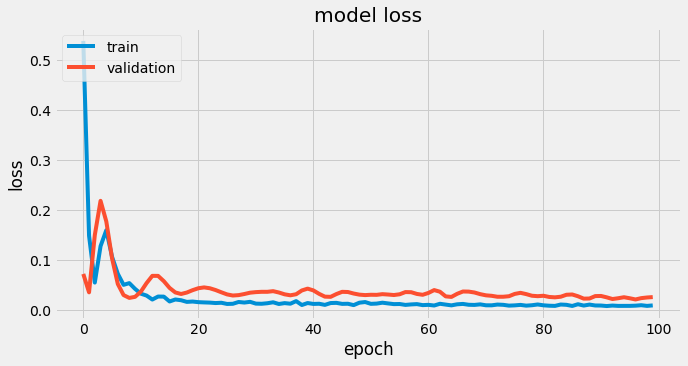

In [49]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

The train loss is higher than the validation loss which means that there is overfitting and room for improvement.

###Model Summary

In [23]:
gru_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 128)               55296     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 55,425
Trainable params: 55,425
Non-trainable params: 0
_________________________________________________________________


###Predict the test data

In [50]:
y_pred = gru_model.predict(X_test)
y_pred

array([[0.2371509 ],
       [0.25638372],
       [0.27961957],
       [0.2516345 ],
       [0.20044285],
       [0.15880996],
       [0.17167638],
       [0.18562621],
       [0.14002176],
       [0.11643714],
       [0.09935544],
       [0.07790926],
       [0.07078447],
       [0.08206425],
       [0.1117231 ],
       [0.08053525],
       [0.05187025],
       [0.08496995],
       [0.23589677],
       [0.31130847],
       [0.28225914],
       [0.21869019]], dtype=float32)

###Inverse transformed data

Scale the data back to the original representation

In [51]:
y_train_inv = cpo_pri_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cpo_pri_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cpo_pri_transformer.inverse_transform(y_pred.reshape(1,-1))
print(y_train_inv)
print(y_test_inv)
print(y_pred_inv)

[[376. 383. 382. 396. 402. 390. 404. 382. 382. 391. 396. 413. 401. 410.
  425. 408. 392. 371. 356. 362. 356. 352. 333. 357. 411. 404. 387. 395.
  434. 488. 508. 494. 575. 614. 616. 707. 719. 655. 661. 687. 625. 611.
  631. 655. 616. 586. 615. 607. 590. 535. 518. 519. 562. 552. 508. 476.
  513. 545. 532. 550. 561. 567. 580. 559. 562. 553. 533. 498. 504. 525.
  547. 556. 566. 621. 659. 671. 688. 705. 633. 661. 674. 703. 694. 681.
  663. 632. 561. 497. 509. 475. 392. 319. 354. 388. 381. 370.]]
[[349. 372. 324. 315. 312. 306. 288. 255. 257. 265. 254. 240. 254. 251.
  234. 255. 330. 362. 310. 277. 323. 360.]]
[[413.86038 421.55347 430.84784 419.6538  399.17715 382.524   387.67056
  393.2505  375.0087  365.57486 358.74216 350.1637  347.31378 351.82568
  363.68924 351.2141  339.7481  352.98798 413.3587  443.5234  431.90366
  406.47607]]


###Plot history, actual and predicted value

In [52]:
y_train_inv = y_train_inv.flatten()
y_train_inv
y_test_inv = y_test_inv.flatten()
y_test_inv

array([349., 372., 324., 315., 312., 306., 288., 255., 257., 265., 254.,
       240., 254., 251., 234., 255., 330., 362., 310., 277., 323., 360.])

In [53]:
#y_pred_inv = y_pred_inv.flatten()
#y_pred_inv

gru_pred = y_pred_inv.flatten()
gru_pred 

array([413.86038, 421.55347, 430.84784, 419.6538 , 399.17715, 382.524  ,
       387.67056, 393.2505 , 375.0087 , 365.57486, 358.74216, 350.1637 ,
       347.31378, 351.82568, 363.68924, 351.2141 , 339.7481 , 352.98798,
       413.3587 , 443.5234 , 431.90366, 406.47607], dtype=float32)

###Plot Actual and Predicted Value

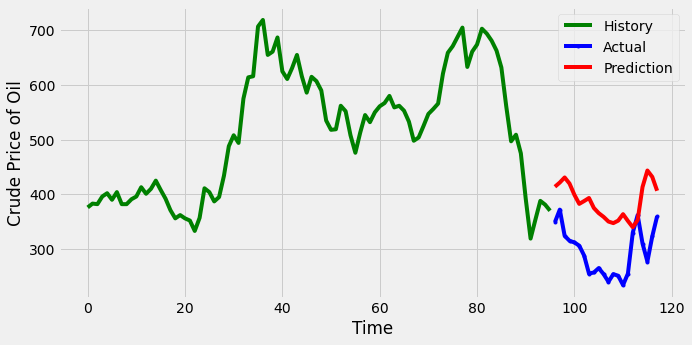

In [54]:
plt.plot(np.arange(0, len(y_train)), y_train_inv, color='green', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, color='blue', marker='.', label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), gru_pred, color='red', label="Prediction")
plt.ylabel('Crude Price of Oil')
plt.xlabel('Time')
plt.legend()
plt.show();

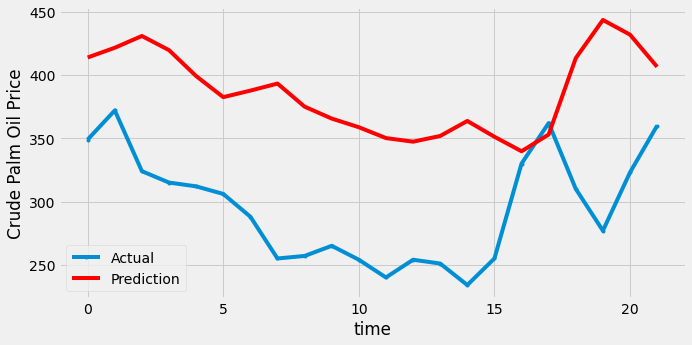

In [55]:
plt.plot(y_test_inv, marker='.', label="Actual")
plt.plot(gru_pred, color='red', label="Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('time')
plt.legend()
plt.show();

In [ ]:
#gru_pred = gru_pred.reshape(-1, 1)

###Evaluate GRU Model Accuracy

In [56]:
MAE_gru = mean_absolute_error(y_test_inv, gru_pred)
print('MAE value of the GRU Model is:', MAE_gru)

MDA_gru = mda(y_test_inv, gru_pred)
print('MDA value of the GRU Model is:', MDA_gru)

MAPE_gru = mean_absolute_percentage_error(y_test_inv, gru_pred)
print('MAPE value of the GRU Model is:', MAPE_gru)

RMSE_gru = mean_squared_error(y_test_inv,gru_pred, squared=False)
print('RMSE value of the GRU Model is:', RMSE_gru)

MSE_gru = mean_squared_error(y_test_inv,gru_pred)
print('MSE value of the GRU Model is:', MSE_gru)

EVS_gru = explained_variance_score(y_test_inv, gru_pred)
print('EVS score of the GRU Model is:', EVS_gru)

MAE value of the GRU Model is: 92.04963129216975
MDA value of the GRU Model is: 0.3333333333333333
MAPE value of the GRU Model is: 33.021722302407284
RMSE value of the GRU Model is: 99.14220287926322
MSE value of the GRU Model is: 9829.176391752988
EVS score of the GRU Model is: 0.15907346175243986


...updating